# Imports

In [1]:
# USE pip install lightly==1.1.17!!!!!!!!!!!!

In [2]:
%matplotlib inline

In [3]:
from tqdm.notebook import tqdm

In [4]:
import torch
import torchvision
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import resnet18
import torch.nn.functional as F
import torch.nn as nn

import pytorch_lightning as pl
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import loggers as pl_loggers

import torchmetrics

import lightly

import matplotlib.pyplot as plt
import numpy as np

import copy

/home/shatz/miniconda3/envs/morebetter3/lib/python3.9/site-packages/lightly/api/version_checking.py:57: Warning: You are using lightly version 1.1.18. There is a newer version of the package available. For compatability reasons, please upgrade your current version: pip install lightly==1.1.20
  warnings.warn(Warning(warning))


In [5]:
seed = 1
pl.seed_everything(seed)

Global seed set to 1


1

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

# device = torch.device("cpu")

device(type='cuda')

# DATA

In [7]:
# data params
num_workers = 6
batch_size = 1

In [8]:
path_to_train = './data/cifar10_lightly/train/'
path_to_test = './data/cifar10_lightly/test/'

In [9]:
# No additional augmentations for the test set
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.ToTensor(),
])

dataset_test = lightly.data.LightlyDataset(
    input_dir=path_to_test,
    transform=test_transforms
)

In [10]:
val_dataloader = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

# MOCO data

In [11]:
# ive made this file because the standard BaseCollateFunction from lightly
# only supports returning x0 and x1 augmentations for some image x. I also want x returned
# to send to the classifier and to add the reconstruction gradient to
from myCollate import BetterSimCLRCollateFunction

In [12]:
# MoCo v2 uses SimCLR augmentations, additionally, disable blur
# collate_fn = lightly.data.SimCLRCollateFunction(
#     input_size=32,
#     gaussian_blur=0.,
# )

collate_fn = BetterSimCLRCollateFunction(
    input_size=32,
    gaussian_blur=0.
)

In [13]:
custom_tfm = torchvision.transforms.Compose([transforms.ToPILImage(), collate_fn.transform,])
custom_tfm;

# Classifier

In [14]:
# # model params
# n_classes=10
# # pretrained_model = "./saved_models/resnet_80/epoch=73-val_loss=0.64-val_acc=0.80.ckpt"
# pretrained_model = "./saved_models/resnet_80/epoch=79-val_loss=0.70-val_acc=0.80.ckpt"
# from plr18 import plr18
# model = plr18().load_from_checkpoint(pretrained_model);

In [15]:
# model params
n_classes=10
# pretrained_model = "./saved_models/resnet_80/epoch=73-val_loss=0.64-val_acc=0.80.ckpt"
# pretrained_model = "./saved_models/resnet_80/epoch=73-val_loss=0.43-val_acc=0.90.ckpt"
pretrained_model = "./saved_models/resnet_80/epoch=73-val_loss=0.43-val_acc=0.90.ckpt"
from plr18_RESNETCOPY import plr18
model = plr18().load_from_checkpoint(pretrained_model);

In [16]:
model.to(device);
model.eval();

# Defense model

In [17]:
memory_bank_size = 4096

In [18]:
# Load my cutom model specifically frozen as fuck for reverse attacks (with some helper methods)
# from moco_model_reverse import ReverseMocoModel
from moco_model_reverse_RESNETCOPY import ReverseMocoModel

In [19]:
moco = ReverseMocoModel(memory_bank_size)
# moco = moco.load_from_checkpoint('./saved_models/resnet_moco/epoch=2989-train_loss_ssl=1.37.ckpt', memory_bank_size=memory_bank_size)
# moco = moco.load_from_checkpoint('./saved_models/resnet_moco/epoch=8765-train_loss_ssl=1.26.ckpt', memory_bank_size=memory_bank_size)
moco = moco.load_from_checkpoint('./saved_models/resnet_moco_RESNETCOPY/epoch=1437-train_loss_ssl=4.99.ckpt', memory_bank_size=memory_bank_size)
moco.eval();

In [20]:
# Holy shit make sure everything is frozen 10 times i dont care

for p in moco.resnet_moco.parameters():  # reset requires_grad
    p.requires_grad = False

moco.freeze()

for p in moco.parameters():
    if p.requires_grad:
        print('BAD')

In [36]:
moco

ReverseMocoModel(
  (resnet_moco): myMoCo(
    (backbone): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (shortcut): Sequential()
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 

# Experiment

In [21]:
batch_limit = 150

In [22]:
epsilons = [0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
            0.01, 0.012, 0.014, 0.016, 0.018, 0.02, 0.023, 0.026, 0.029, 0.034,
            .05, .1, .15, .2, 0.3]

epsilons = [0, 0.001, 0.002, 0.007, 0.008,
            0.01, 0.012, 0.016, 0.018, 0.02, 0.023, 0.026, 0.029, 0.034]
            #.05, .07] # , .1, .15, .2, 0.3]

In [23]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [24]:
def reverse_fgsm_n_times(data, defender, n, epsilon):
    fixed_data = data.clone()
    for i in range(n):
        fixed_x0 = custom_tfm(data.squeeze(0)).to(device)
        fixed_x1 = custom_tfm(data.squeeze(0)).to(device)
        x0g, _, _ = defender.contrastive_loss(fixed_x0.unsqueeze(0), fixed_x1.unsqueeze(0))
        fixed_data = reverse_fgsm_attack(fixed_data, epsilon, x0g)
    return fixed_data

In [25]:
def reverse_fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    fixed_image = image - epsilon*sign_data_grad
    fixed_image = torch.clamp(fixed_image, 0, 1)
    return fixed_image

In [26]:
def make_semisup_pairs(data):
    x0 = custom_tfm(data.squeeze(0))
    x1 = custom_tfm(data.squeeze(0))
    return x0.to(device).unsqueeze(0), x1.to(device).unsqueeze(0)

In [27]:
def test2( classifier, defender, test_loader, epsilon, batch_limit=100):

    ### Things that will be returned ###
    correct = 0
    fixed_correct = 0
    og_contrastive_loss_avg = 0
    grad_perturbed_contrastive_loss_avg = 0
    fixed_contrastive_loss_avg = 0
    adv_examples = []
    
    ## set up models ##
    classifier = classifier.to(device)
    defender.eval()
    defender = defender.to(device)

    # Loop over all examples in test set
    for sample in enumerate(tqdm(val_dataloader)):

        # Send the data and label to the device
        # data, target = data.to(device), target.to(device)
        (idx, (data, target, filename)) = sample
        
        # Set requires_grad attribute of tensor. Important for Attack
        data = data.to(device)
        data.requires_grad = True
        target = target.to(device)

        # Forward pass the data through the model
        output = classifier(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)
        classifier.zero_grad()
        loss.backward()
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        
        # Re-classify the perturbed image
        output = classifier(perturbed_data)
        
        ### Semi supervised part ###
        # get data pairs
        x0, x1 = make_semisup_pairs(data)
        x0_perturbed, x1_perturbed = make_semisup_pairs(perturbed_data)
        
        ### safety check was here ###
        # x0_c = x0.detach().clone()
        # x1_c = x1.detach().clone()
        # x0p_c = x0_perturbed.detach().clone()
        # x1p_c = x1_perturbed.detach().clone()
        
        # contrastive loss
        og_contrastive_loss = defender.contrastive_loss_nograd(x0, x1)
        x0g, x1g, grad_perturbed_contrastive_loss = defender.contrastive_loss(x0_perturbed, x1_perturbed)
        
        ### now repair the perturbed image using its grad ###
        # fixed_data = 
        fixed_data = reverse_fgsm_attack(perturbed_data, epsilon, x0g)
        
        # also try fixing multiple times like the paper
        # fixed_data_loop = reverse_fgsm_n_times(perturbed_data, defender, 3, epsilon)
        
        # reclassify fixed image
        with torch.no_grad():
            fixed_output = classifier(fixed_data)
        
        # also get the new contrastive loss (for research purposes)
        fixed_x0, fixed_x1 = make_semisup_pairs(fixed_data)
        _, _, fixed_contrastive_loss = defender.contrastive_loss(fixed_x0, fixed_x1)        
        
        og_contrastive_loss_avg += og_contrastive_loss
        grad_perturbed_contrastive_loss_avg += grad_perturbed_contrastive_loss
        fixed_contrastive_loss_avg += fixed_contrastive_loss

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        fixed_final_pred = fixed_output.max(1, keepdim=True)[1]
        if fixed_final_pred.item() == target.item():
            fixed_correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        if batch_limit:
            if idx > batch_limit:
                break

    # Calculate final accuracy for this epsilon
    div = min(float(len(test_loader)), float(batch_limit))
    final_acc = correct/div
    fixed_final_acc = fixed_correct/div
    og_contrastive_loss_avg = og_contrastive_loss_avg / div
    grad_perturbed_contrastive_loss_avg = grad_perturbed_contrastive_loss_avg / div
    fixed_contrastive_loss_avg = fixed_contrastive_loss_avg / div
    print(f"Epsilon: {epsilon:.4f}\tTest Accuracy = {correct}/{div} = {final_acc}\t Repaired Accuracy = {fixed_final_acc}\n og_cont_loss = {og_contrastive_loss_avg:.4f} | grad_pert_cont_loss = {grad_perturbed_contrastive_loss_avg:.4f} | fixed_contrastive_loss = {fixed_contrastive_loss_avg:.4f}")
    # Return the accuracy and an adversarial example
    return final_acc, fixed_final_acc, adv_examples, og_contrastive_loss_avg, grad_perturbed_contrastive_loss_avg, fixed_contrastive_loss_avg

In [28]:
accuracies = []
fixed_accuracies = []
examples = []
og_contrastive_losses = []
# perturbed_contrastive_losses = []
grad_perturbed_contrastive_losses = []
fixed_contrastive_losses = []

# Run test for each epsilon
for eps in tqdm(epsilons):
    acc, fixed_acc, ex, og_contrastive_loss, grad_perturbed_contrastive_loss, fixed_contrastive_loss =\
    test2(model, moco, val_dataloader, eps, batch_limit=batch_limit)
    accuracies.append(acc)
    examples.append(ex)
    og_contrastive_losses.append(og_contrastive_loss)
    grad_perturbed_contrastive_losses.append(grad_perturbed_contrastive_loss)
    fixed_contrastive_losses.append(fixed_contrastive_loss)
    fixed_accuracies.append(fixed_acc)

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.0000	Test Accuracy = 137/150.0 = 0.9133333333333333	 Repaired Accuracy = 0.9133333333333333
 og_cont_loss = 3.1634 | grad_pert_cont_loss = 3.2319 | fixed_contrastive_loss = 3.0631


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.0010	Test Accuracy = 121/150.0 = 0.8066666666666666	 Repaired Accuracy = 0.8
 og_cont_loss = 3.4616 | grad_pert_cont_loss = 2.9969 | fixed_contrastive_loss = 3.0738


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.0020	Test Accuracy = 105/150.0 = 0.7	 Repaired Accuracy = 0.7
 og_cont_loss = 3.1303 | grad_pert_cont_loss = 3.1029 | fixed_contrastive_loss = 3.3103


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.0070	Test Accuracy = 33/150.0 = 0.22	 Repaired Accuracy = 0.2733333333333333
 og_cont_loss = 3.1980 | grad_pert_cont_loss = 3.2913 | fixed_contrastive_loss = 3.3047


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.0080	Test Accuracy = 29/150.0 = 0.19333333333333333	 Repaired Accuracy = 0.2
 og_cont_loss = 3.1214 | grad_pert_cont_loss = 3.7084 | fixed_contrastive_loss = 3.5538


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.0100	Test Accuracy = 19/150.0 = 0.12666666666666668	 Repaired Accuracy = 0.16666666666666666
 og_cont_loss = 3.1384 | grad_pert_cont_loss = 3.5183 | fixed_contrastive_loss = 3.4942


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.0120	Test Accuracy = 13/150.0 = 0.08666666666666667	 Repaired Accuracy = 0.08
 og_cont_loss = 3.5291 | grad_pert_cont_loss = 3.1791 | fixed_contrastive_loss = 3.7023


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.0160	Test Accuracy = 5/150.0 = 0.03333333333333333	 Repaired Accuracy = 0.04
 og_cont_loss = 3.3940 | grad_pert_cont_loss = 3.4566 | fixed_contrastive_loss = 3.5318


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.0180	Test Accuracy = 3/150.0 = 0.02	 Repaired Accuracy = 0.04
 og_cont_loss = 2.9557 | grad_pert_cont_loss = 3.5482 | fixed_contrastive_loss = 3.4943


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.0200	Test Accuracy = 1/150.0 = 0.006666666666666667	 Repaired Accuracy = 0.006666666666666667
 og_cont_loss = 3.2989 | grad_pert_cont_loss = 3.4144 | fixed_contrastive_loss = 3.5302


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.0230	Test Accuracy = 1/150.0 = 0.006666666666666667	 Repaired Accuracy = 0.006666666666666667
 og_cont_loss = 3.0519 | grad_pert_cont_loss = 3.5080 | fixed_contrastive_loss = 3.0630


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.0260	Test Accuracy = 0/150.0 = 0.0	 Repaired Accuracy = 0.006666666666666667
 og_cont_loss = 3.4283 | grad_pert_cont_loss = 3.6273 | fixed_contrastive_loss = 3.7109


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.0290	Test Accuracy = 0/150.0 = 0.0	 Repaired Accuracy = 0.0
 og_cont_loss = 3.1187 | grad_pert_cont_loss = 3.7070 | fixed_contrastive_loss = 3.5636


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.0340	Test Accuracy = 0/150.0 = 0.0	 Repaired Accuracy = 0.006666666666666667
 og_cont_loss = 3.3274 | grad_pert_cont_loss = 3.4829 | fixed_contrastive_loss = 3.7451


# 📈 Results 📉

In [29]:
RESULTS_DIR = "./results/"

In [30]:
og_contrastive_losses = [t.cpu().detach().numpy() for t in og_contrastive_losses]
grad_perturbed_contrastive_losses = [t.cpu().detach().numpy() for t in grad_perturbed_contrastive_losses]
fixed_contrastive_losses = [t.cpu().detach().numpy() for t in fixed_contrastive_losses]

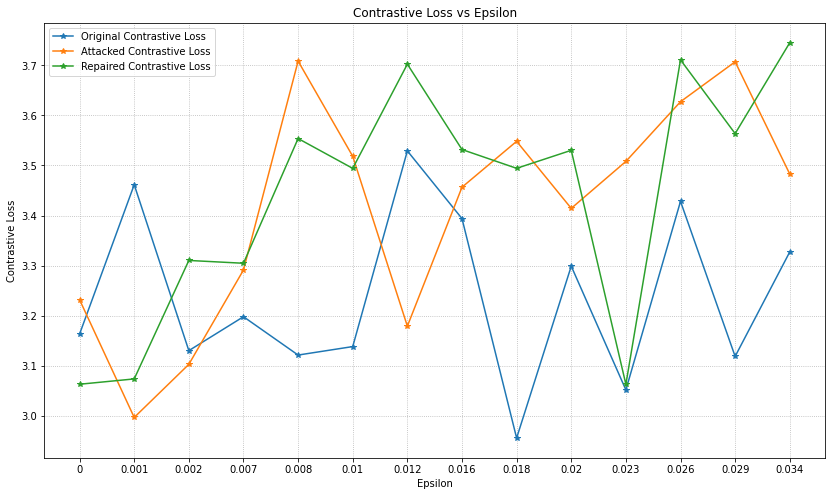

In [31]:
# equally distanced plots
plt.figure(figsize=(14,8))

plt.plot(range(len(epsilons)), og_contrastive_losses, "*-", label='Original Contrastive Loss')
plt.plot(range(len(epsilons)), grad_perturbed_contrastive_losses, "*-", label='Attacked Contrastive Loss')
plt.plot(range(len(epsilons)), fixed_contrastive_losses, "*-", label='Repaired Contrastive Loss')

plt.xticks(range(len(epsilons)), epsilons)
plt.title("Contrastive Loss vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Contrastive Loss")
plt.legend()
plt.grid(linestyle=':')
plt.savefig(RESULTS_DIR+"contrastive_loss")
plt.show()

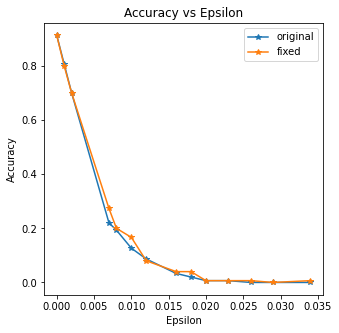

In [32]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-", label="original")
plt.plot(epsilons, fixed_accuracies, "*-", label="fixed")
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(RESULTS_DIR+"accuracy.png")
plt.show()

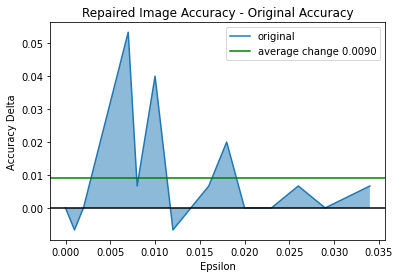

In [33]:
# Plot diff between original and fixed accuracys

diff = np.array(fixed_accuracies) - np.array(accuracies)
avg_diff = np.average(diff)

# plt.figure(figsize=(5,5))
plt.plot(epsilons, diff, label="original")
plt.axhline(y=0, color='black', linestyle='-')
plt.axhline(y=avg_diff, color='g', linestyle='-', label=f"average change {avg_diff:.4f}")
plt.fill_between(epsilons, 0, diff, alpha=0.5)

plt.title("Repaired Image Accuracy - Original Accuracy")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy Delta")
plt.legend()
plt.savefig(RESULTS_DIR+"diff.png")
plt.show()

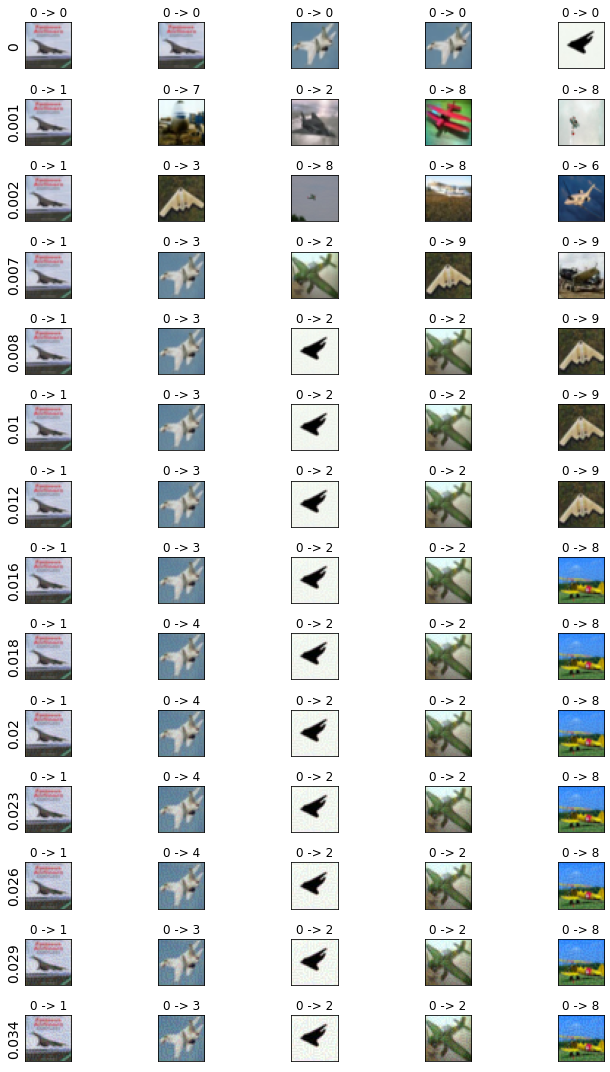

In [34]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(10, 15))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("{}".format(epsilons[i]), fontsize=14) # eps 
        orig,adv,ex = examples[i][j]
        ex = np.moveaxis(ex, 0, -1)
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.savefig(RESULTS_DIR+"pics.png")
plt.show()

In [35]:
from datetime import datetime

now = datetime.now()

current_time = now.strftime("%H:%M:%S on %d/%m/%y (hr:min:sec on day/mo/yr)")
print("Current Time =", current_time)

file = open(RESULTS_DIR+"readme.txt", 'a')
file.write(f'Experiment finished at: {current_time}\n');

Current Time = 11:56:54 on 18/10/21 (hr:min:sec on day/mo/yr)


# NOTES

1. Some hacks I made in the lightly library to make this work: 

    Line 100 in `lightly/loss/nxt_ent_loss.py`
    - `super(NTXentLoss, self).forward(out1, update=out0.requires_grad and update_memory_bank)`
    - This should not be breaking, but I should update library later and make this a pull request. Reason: sometimes you want to see the loss for a data sample without updating the memory bank. Such as in my research.

    Line 106 in `lightly/models/moco.py`
    - `# self._momentum_update(self.m)`
    - commented this out to not update momentum. Consider contributing this as well. This is breaking, so I cant train until I fix this.
    
    
2. Hacks have now been moved into classes I built and overrode their code. Best to integrate these changes in pull requests anyway. Get me sum resume pts :)